# YOLO V2

- Object Detection Only

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import xml.etree.ElementTree as ET
import tensorflow as tf

devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)
    
from tensorflow import keras
from keras import Sequential, Model
from multiprocessing import Pool

## Data Preparation 

- We will extract xmin,ymin,xmax & ymax for each object in an image.
- Next we will resize and rescale both the images and ground truth coordinates to (416,416)

In [2]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

train_image_folder = "JPEGImages/"
train_annot_folder = "Annotations/"

In [3]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


In [4]:
train_image[1]

{'object': [{'name': 'aeroplane',
   'xmin': 104,
   'ymin': 78,
   'xmax': 375,
   'ymax': 183},
  {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
  {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
  {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
 'filename': 'JPEGImages/2007_000032.jpg',
 'width': 500,
 'height': 281}

In [5]:
def fun(x,H,W):
    
    w = x['width']       # image height and width 
    h = x['height']
    
    attr = []
    for i in x['object']:
        
        t = {}
        
        xmin = i['xmin']*W/w     # scale the coordinates to (W,H) == (416,416).
        xmax = i['xmax']*W/w
        
        ymin = i['ymin']*H/h
        ymax = i['ymax']*H/h
        
        name = i['name']
        
        t['name'] = name
        t['xmin'] = xmin
        t['ymin'] = ymin
        t['xmax'] = xmax
        t['ymax'] = ymax
        
        attr.append(t)
    
    image = cv2.imread(x['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(W,H))/255  # resize to (416,416) and normalize.
    
    return image,attr

In [6]:
# example of resized image and coordinates
img,attr = fun(train_image[1],416,416)

attr

[{'name': 'aeroplane',
  'xmin': 86.528,
  'ymin': 115.47330960854093,
  'xmax': 312.0,
  'ymax': 270.9181494661922},
 {'name': 'aeroplane',
  'xmin': 110.656,
  'ymin': 130.27758007117438,
  'xmax': 163.904,
  'ymax': 182.09252669039145},
 {'name': 'person',
  'xmin': 162.24,
  'ymin': 266.47686832740214,
  'xmax': 177.216,
  'ymax': 339.01779359430606},
 {'name': 'person',
  'xmin': 21.632,
  'ymin': 279.80071174377224,
  'xmax': 36.608,
  'ymax': 352.34163701067615}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


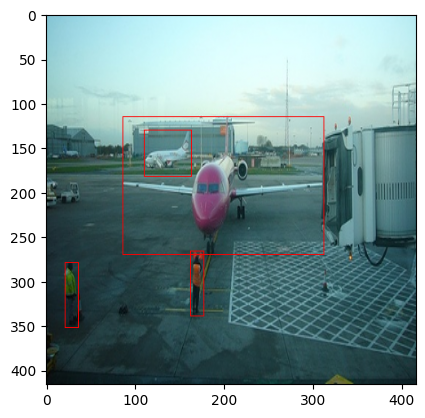

In [7]:
# Draw the bounding box on the image
color = (255, 0, 0)  # Blue color in BGR format
thickness = 1  # Thickness of the bounding box line

for i in attr:
    
    xmin = int(i['xmin'])
    xmax = int(i['xmax'])
    ymin = int(i['ymin'])
    ymax = int(i['ymax'])
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    
plt.imshow(img)

- Yolo accepts coordinates as centre_x, centre_y , width and height.

- The following function helps obtain those values

In [8]:
def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_centerwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

In [9]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_centerwh(obj,config)

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


## Anchor Boxes

YOLO uses an idea of "Anchor box" to wisely detect multiple objects, lying in close neighboorhood. 

- the 1st anchor box specializes small flat rectangle bounding box
- the 2nd anchor box specializes small tall rectangle bounding box
- the 3rd anchor box specializes large flat rectangle bounding box
- the 4th anchor box specializes large tall rectangle bounding box

In [10]:
def calculate_anchor_iou(box1,box2):
    w1,h1 = box1
    w2,h2 = box2
    
    a1 = w1*h1
    a2 = w2*h2
    
    if a1>a2:
        return a2/a1
    else:
        return a1/a2
    
    
ANCHORS = [[0.08285376,0.13705531],[0.20850361,0.39420716],[0.80552421,0.77665105],[0.42194719,0.62385487]]
ANCHORS = [[value * 13 for value in sublist] for sublist in ANCHORS]  # 13 = GRIDs
ANCHORS

[[1.0770988799999999, 1.78171903],
 [2.71054693, 5.12469308],
 [10.47181473, 10.09646365],
 [5.48531347, 8.11011331]]

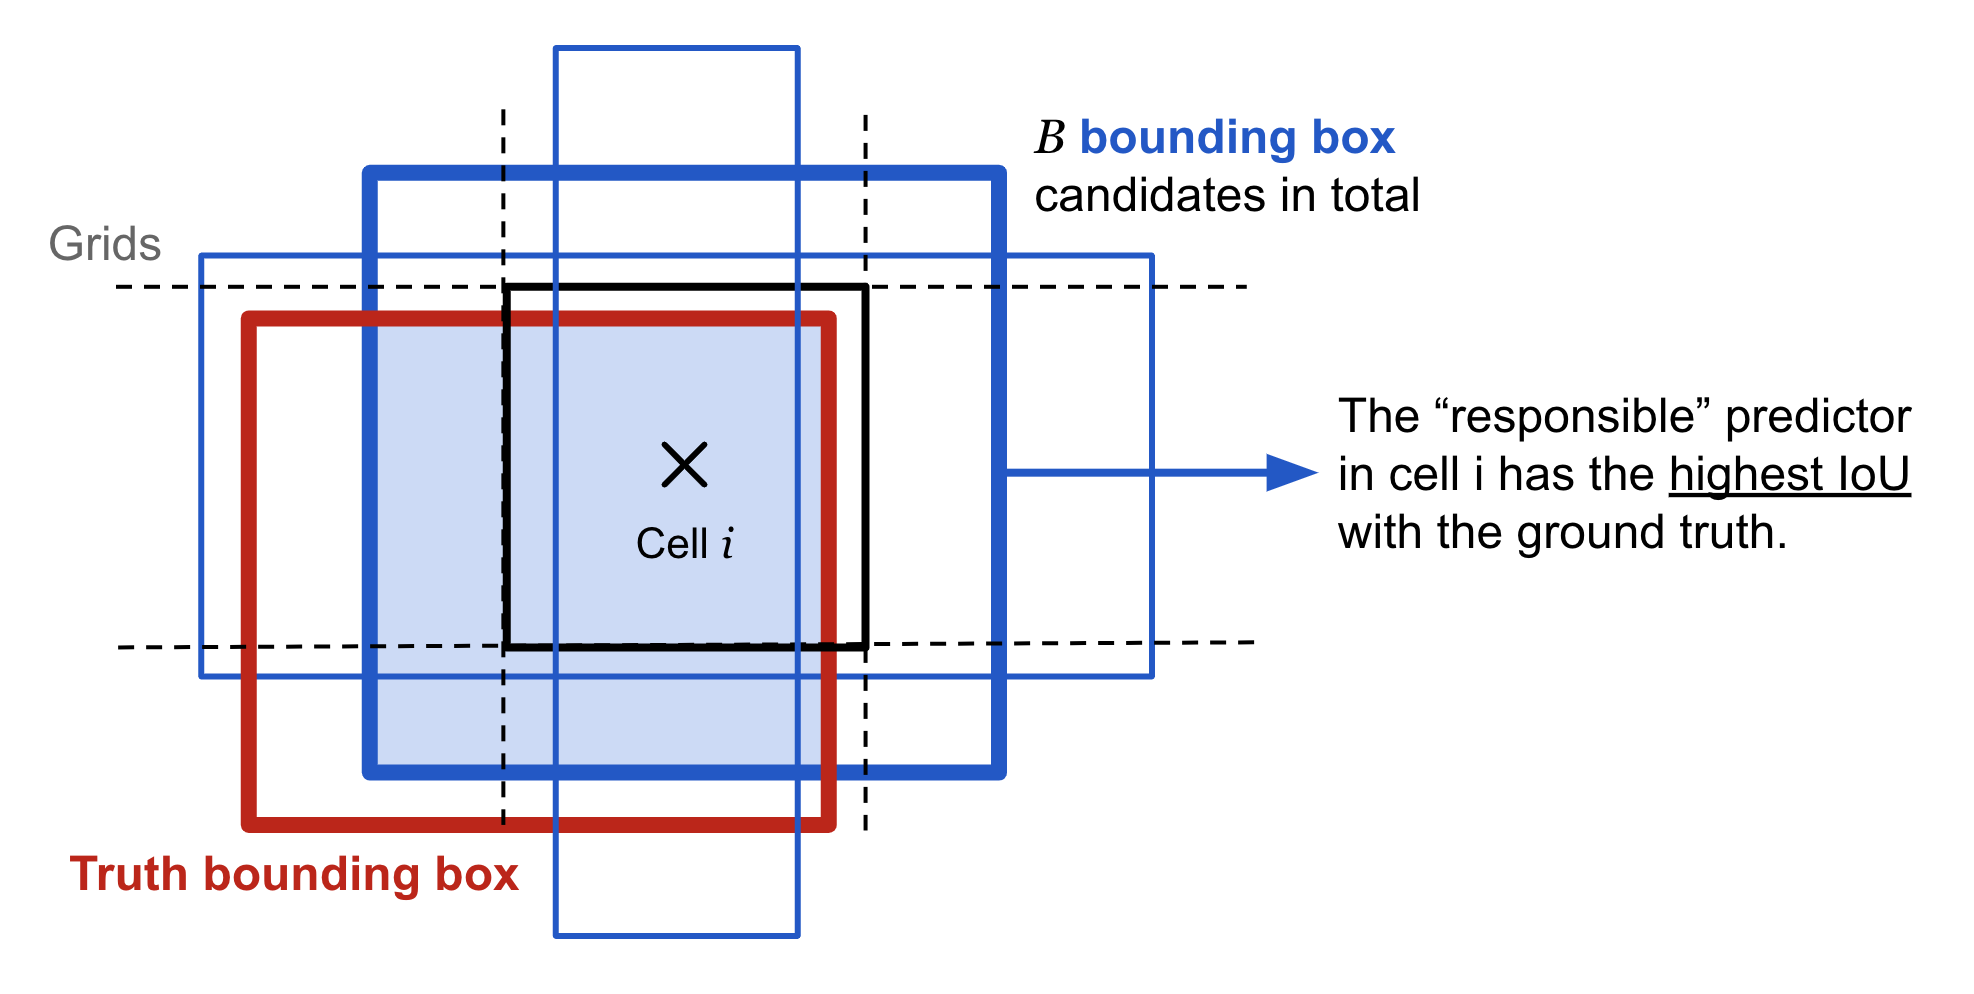



- there are (13,13) grid cells and each cell has 4 anchor boxes.
- based on the height and width of the objects in an image we calculate the iou with the predefined anchor boxes.
- the the anchor box with the highest iou gets assigned the 4 coordinates (centre_x,centre_y,width,height) of the ground truth bounding box of each object in the cell

- the grid cell to which the coordinates are assigned is based on (centre_x,centre_y).
- the scale of all the values is from 0 to 13.

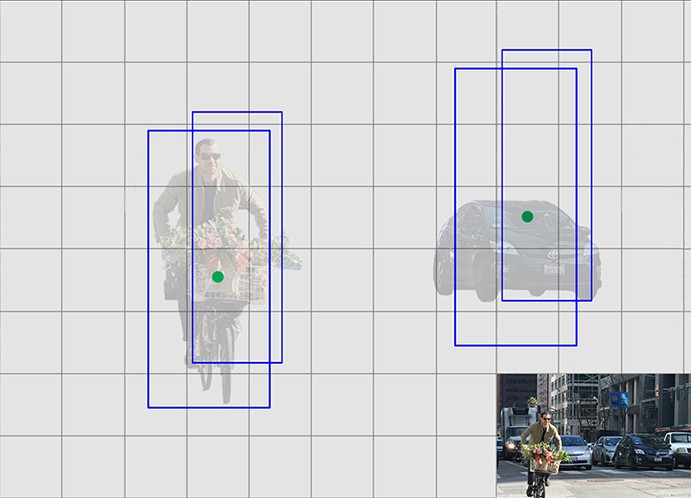

In [11]:
def process_single_sample(j):
    img, attr = fun(train_image[j], 416, 416)
    
    t = np.zeros((13, 13, 4, 4+1))
    batch_box = np.zeros(shape=(75, 4))
    i_ = 0
    for i in attr:
        x, y = rescale_centerxy(i, config)
        w, h = rescale_centerwh(i, config)
        K = [calculate_anchor_iou([w,h], k) for k in ANCHORS]
        best_anchor = int(np.argmax(K))
        obj_idx = LABELS.index(i['name'])
        
        t[int(np.floor(y)), int(np.floor(x)), best_anchor, 0:4] = [x, y, w, h]
        t[int(np.floor(y)), int(np.floor(x)), best_anchor, 4] = 1
        
        batch_box[i_] = [x, y, w, h]
        i_ += 1
    
    return img, t, batch_box

def data_generator():
    for j in range(1000):  # Adjust this range as needed
        yield process_single_sample(j)

# Create the dataset
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_types=(tf.float32, tf.float32, tf.float32),
    output_shapes=((416, 416, 3), (13, 13, 4, 5), (75, 4))
)

# Shuffle and batch the dataset
BATCH_SIZE = 32
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# If you need to use multiprocessing for even faster processing:
def parallel_process_samples(num_samples):
    with Pool() as p:
        return p.map(process_single_sample, range(num_samples))

# Use this function if you need all data at once (try to avoid if possible):
# all_data = parallel_process_samples(1000)
# images, target, b = zip(*all_data)
# images = np.array(images)
# target = np.array(target)
# b = np.array(b)

2024-06-27 11:31:41.786529: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-27 11:31:41.786549: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-06-27 11:31:41.786553: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-06-27 11:31:41.786628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-27 11:31:41.786643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
def iou(box1, box2):
    # Box coordinates of prediction
    b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
    b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
    b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
    b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

    # Box coordinates of ground truth
    b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
    b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
    b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
    b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

    # Get the coordinates of the intersection rectangle
    x1 = tf.maximum(b1_x1, b2_x1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x2 = tf.minimum(b1_x2, b2_x2)
    y2 = tf.minimum(b1_y2, b2_y2)

    # Make sure the intersection is at least 0
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # Calculate the union area
    box1_area = tf.abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
    box2_area = tf.abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
    union = box1_area + box2_area - intersection

    # Calculate the IoU score
    epsilon = 1e-6
    iou_score = intersection / (union + epsilon)

    return iou_score

## Scaling Prediction Values

- YOLO v2 predicts five coordinates per bounding box. (tx, ty, tw, th, and to)
- the following is done for faster convergence. Since original prediction values can be have high variance, we need to constrain them first.

\begin{align}
b_x &= \sigma(t_x) + c_x \quad (c_x \text{ is the offset from the left of the image}) \\
b_y &= \sigma(t_y) + c_y \quad (c_y \text{ is the offset from the top of the image})
\end{align}


\begin{align}
b_w &= p_w e^{t_w} \quad (p_w \text{ is the width of anchor box}) \\
b_h &= p_h e^{t_h} \quad (p_h \text{ is the height of anchor box})
\end{align}

\begin{align}
Pr(\text{object}) \times \text{IoU}(b, \text{object}) &= \sigma(t_o)
\end{align}

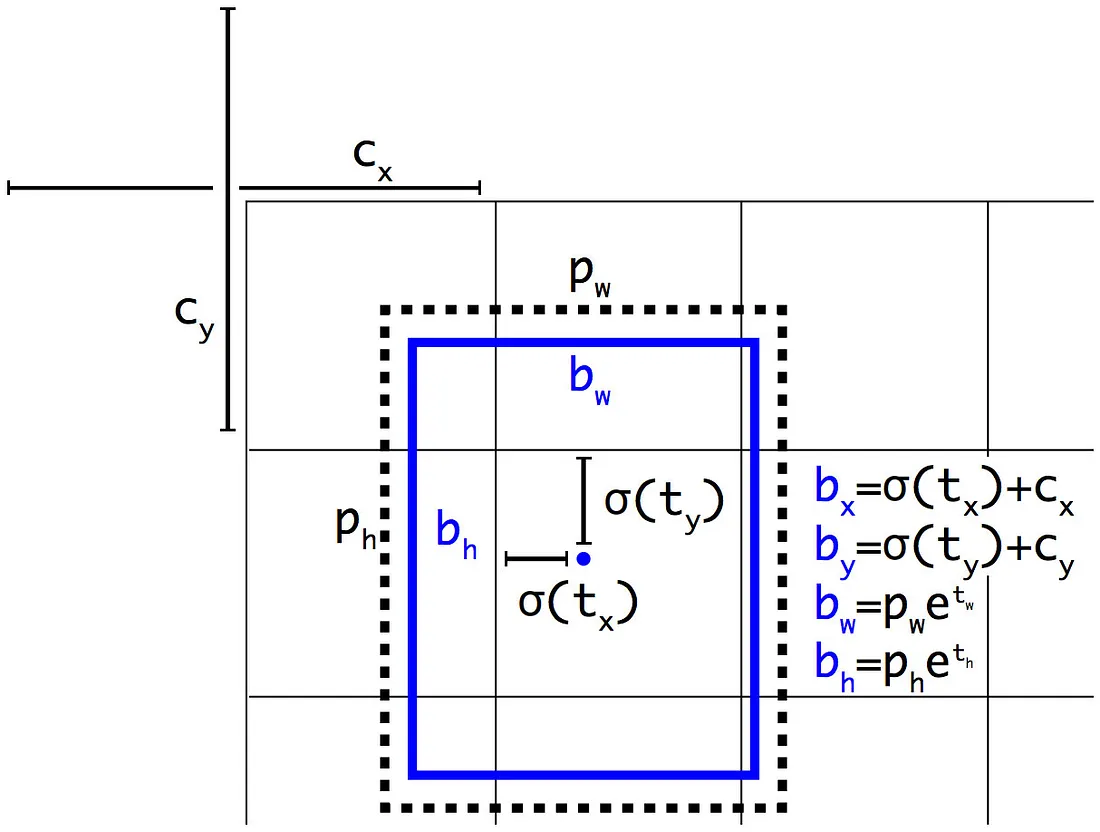


In [13]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)),tf.float32)

    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
   
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    
    return(cell_grid) 


cell_grid = get_cell_grid(13,13,1,4)


def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    

    BOX = 4

    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb
    
    return(pred_box_xy,pred_box_wh,pred_box_conf)

def extract_ground_truth(y_true):    
    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 

    return(true_box_xy, true_box_wh, true_box_conf)

## Loss Function
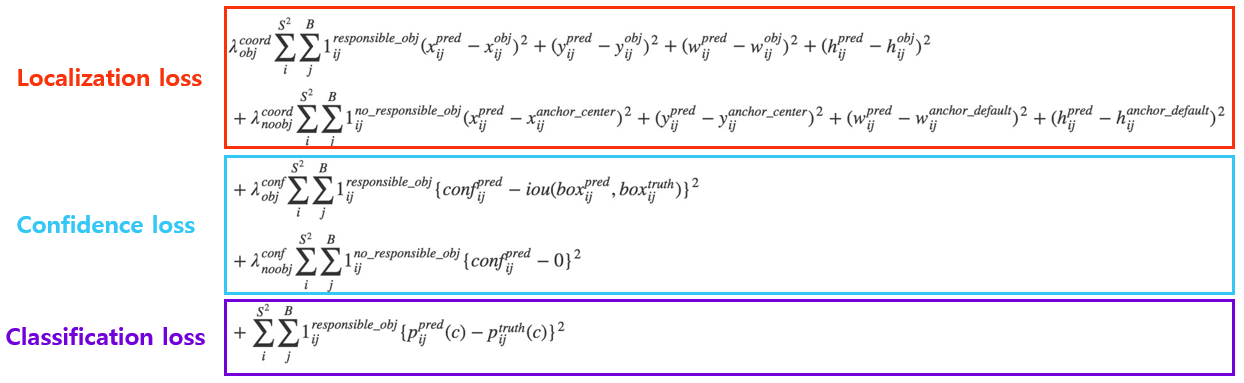

In [14]:
def calc_loss_xywh(true_box_conf,COORD_SCALE,true_box_xy, pred_box_xy,true_box_wh,pred_box_wh):  

    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0,tf.float32))
    loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    return(loss_xy ,loss_wh, coord_mask)

**To improve object detection accuracy, I've implemented a strategy to leverage multiple anchor boxes for each object.**

* **Identifying "Good" Anchors:**  For every object in an image, I calculate the IOU (Intersection over Union) between the object's bounding box and each of the 4 anchor boxes in each of the 13x13 grid cells. This results in a large tensor (1, 75, 13, 13, 4) representing all IOUs.
* **Finding Best Matches:** I then find the highest IOU for each anchor box across all objects. This gives me a tensor of shape (1, 13, 13, 4) containing the best IOUs for each anchor.
* **Thresholding:** To identify promising anchors, I set a threshold of 0.6.  Anchors with best IOUs above this threshold are considered "good" and are marked as 1, while the rest are marked as 0.

**Rationale:** During data preparation, we typically assign only the single best anchor box to each ground truth object. However, other anchor boxes may still be quite effective at predicting the object's location. By identifying these additional "good" anchors, I can encourage the model to explore a wider range of potential predictions, leading to better overall detection performance. 

- i finally apply binary cross entropy between the predicted confidence and our iou based adjusted confidence. 
- it will allow the model to push our good anchor box prediction to value of 1.

In [15]:
def obj_iou_loss(true_box_conf,best_ious,pred_box_conf):

    obj_mask = tf.maximum(tf.cast(true_box_conf > 0, tf.float32),tf.cast(tf.math.reduce_max(best_ious, axis=1) >0.6,tf.float32))
    
    n = tf.reduce_sum(obj_mask)
    
    true_box_conf_ = tf.maximum(tf.cast(true_box_conf > 0, tf.float32),tf.cast(tf.math.reduce_max(best_ious, axis=1) >0.6,tf.float32))
    pred_box_conf_ = pred_box_conf*obj_mask
    
    epsilon = 1e-7
    
    loss = tf.keras.losses.BinaryCrossentropy(reduction='sum')(true_box_conf_,pred_box_conf_)/ (n + epsilon)   # mean squard error ?
    
    return loss

- the same concept applied to no object loss where except the best and all good anchor boxes(>0.6), the model tries to reduce the confidence score of rest   all anchor boxes to zero.

In [16]:
def no_obj_loss(true_box_conf, pred_box_conf,best_ious):

    no_obj_mask = (1 -tf.cast(true_box_conf,tf.float32))*tf.cast(tf.math.reduce_max(best_ious, axis=1) < 0.6,tf.float32)
    

    n = tf.reduce_sum(tf.cast(no_obj_mask > 0, tf.float32))
    
    
    squared_diff = tf.square(true_box_conf - pred_box_conf)
    masked_squared_diff = squared_diff * no_obj_mask
    
    
    # Add a small epsilon to prevent division by zero
    epsilon = 1e-7
    loss = tf.reduce_sum(masked_squared_diff) / (n + epsilon)
    
    return loss

As stated earlier 

- For every object in an image, I calculate the IOU (Intersection over Union) between the object's bounding box and each of the 4 anchor boxes in each of the 13x13 grid cells. This results in a large tensor (1, 75, 13, 13, 4) representing all IOUs.

In [17]:
def calculate_best_iou(pred_boxes_, true_boxes_):
    # Convert center coordinates to corner coordinates
    def center_to_corner(boxes):
        x, y, w, h = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3]
        x1, y1 = x - w/2, y - h/2
        x2, y2 = x + w/2, y + h/2
        return tf.stack([x1, y1, x2, y2], axis=-1)
    
    pred_boxes = center_to_corner(pred_boxes_)
    true_boxes = center_to_corner(true_boxes_)
    
    # Expand dimensions for broadcasting
    pred_boxes = tf.expand_dims(pred_boxes, axis=4)
    true_boxes = tf.expand_dims(tf.expand_dims(tf.expand_dims(true_boxes, axis=1), axis=1), axis=1)
    
    # Calculate intersection
    inter_x1 = tf.maximum(pred_boxes[..., 0], true_boxes[..., 0])
    inter_y1 = tf.maximum(pred_boxes[..., 1], true_boxes[..., 1])
    inter_x2 = tf.minimum(pred_boxes[..., 2], true_boxes[..., 2])
    inter_y2 = tf.minimum(pred_boxes[..., 3], true_boxes[..., 3])
    
    inter_w = tf.maximum(0.0, inter_x2 - inter_x1)
    inter_h = tf.maximum(0.0, inter_y2 - inter_y1)
    intersection = inter_w * inter_h
    
    # Calculate areas
    pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
    true_area = (true_boxes[..., 2] - true_boxes[..., 0]) * (true_boxes[..., 3] - true_boxes[..., 1])
    
    # Calculate IoU
    union = pred_area + true_area - intersection
    iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    
    # Transpose to get the desired shape (1000, 50, 13, 13, 4)
    iou = tf.transpose(iou, perm=[0, 4, 1, 2, 3])
    
    return iou


Final Loss Function

In [18]:
def custom_loss(y_true, y_pred,true_boxes_batch):
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(13,13,1,4)
    
    pred_box_xy, pred_box_wh, pred_box_conf = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf = extract_ground_truth(y_true)
    
    # Step 3: Calculate loss for the bounding box parameters
    loss_xy,loss_wh, coord_mask = calc_loss_xywh(true_box_conf,1,true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    
    y_pred_ = tf.concat([pred_box_xy,pred_box_wh],axis=-1)
    
    best_ious = calculate_best_iou(y_pred_[...,:4], true_boxes_batch)
    
    obj_iou_loss_ = obj_iou_loss(true_box_conf,best_ious,pred_box_conf)
    
    no_obj_loss_ = no_obj_loss(true_box_conf,pred_box_conf,best_ious)

    loss = loss_xy+10*loss_wh + 10*obj_iou_loss_ +no_obj_loss_ 
    
    return loss #loss_xy,loss_wh ,no_obj_loss_, obj_iou_loss_

## Darknet 19





In [19]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import concatenate
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal,RandomNormal

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

def ConvBatchLReLu(x,filters,kernel_size,index):
    # when strides = None, strides = pool_size.
    x = Conv2D(filters, kernel_size, strides=(1,1), 
               padding='same', name='conv_{}'.format(index), 
               use_bias=False,kernel_initializer=HeNormal())(x)
    x = BatchNormalization(name='norm_{}'.format(index))(x)
    x = LeakyReLU(alpha=0.1)(x)
    return(x)

def ConvBatchLReLu_loop(x,index,convstack):
    for para in convstack:
        x = ConvBatchLReLu(x,para["filters"],para["kernel_size"],index)
        index += 1
    return(x)

def define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,BOX):
    
    convstack3to5  = [{"filters":128, "kernel_size":(3,3)},  # 3
                      {"filters":64,  "kernel_size":(1,1)},  # 4
                      {"filters":128, "kernel_size":(3,3)}]  # 5
                    
    convstack6to8  = [{"filters":256, "kernel_size":(3,3)},  # 6
                      {"filters":128, "kernel_size":(1,1)},  # 7
                      {"filters":256, "kernel_size":(3,3)}]  # 8
    
    convstack9to13 = [{"filters":512, "kernel_size":(3,3)},  # 9
                      {"filters":256, "kernel_size":(1,1)},  # 10
                      {"filters":512, "kernel_size":(3,3)},  # 11
                      {"filters":256, "kernel_size":(1,1)},  # 12
                      {"filters":512, "kernel_size":(3,3)}]  # 13
        
    convstack14to20 = [{"filters":1024, "kernel_size":(3,3)}, # 14 
                       {"filters":512,  "kernel_size":(1,1)}, # 15
                       {"filters":1024, "kernel_size":(3,3)}, # 16
                       {"filters":512,  "kernel_size":(1,1)}, # 17
                       {"filters":1024, "kernel_size":(3,3)}, # 18
                       {"filters":1024, "kernel_size":(3,3)}, # 19
                       {"filters":1024, "kernel_size":(3,3)}] # 20
    
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3),name="input_image")
 
    # Layer 1
    x = ConvBatchLReLu(input_image,filters=32,kernel_size=(3,3),index=1)
    
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_416to208")(x)
    # Layer 2
    x = ConvBatchLReLu(x,filters=64,kernel_size=(3,3),index=2)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_208to104")(x)
    
    # Layer 3 - 5
    x = ConvBatchLReLu_loop(x,3,convstack3to5)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_104to52")(x)
    
    # Layer 6 - 8 
    x = ConvBatchLReLu_loop(x,6,convstack6to8)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_52to26")(x) 

    # Layer 9 - 13
    x = ConvBatchLReLu_loop(x,9,convstack9to13)
        
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_26to13")(x)
    
    # Layer 14 - 20
    x = ConvBatchLReLu_loop(x,14,convstack14to20)

    # Layer 21
    skip_connection = ConvBatchLReLu(skip_connection,filters=64,
                                     kernel_size=(1,1),index=21)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = ConvBatchLReLu(x,filters=1024,kernel_size=(3,3),index=22)

    # Layer 23
    x = Conv2D(BOX * (4 + 1), (1,1), strides=(1,1), padding='same', name='conv_23',kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1),name="final_output")(x)

    model = Model(input_image, output)
    return model

IMAGE_H, IMAGE_W  = 416, 416

GRID_H,  GRID_W   = 13 , 13

BOX               = 4

## true_boxes is the tensor that takes "b_batch"
model = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,BOX)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 416, 416, 32)         864       ['input_image[0][0]']         
                                                                                                  
 norm_1 (BatchNormalization  (None, 416, 416, 32)         128       ['conv_1[0][0]']              
 )                                                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['norm_1[0][0]']          

 n)                                                                                               
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)   (None, 26, 26, 256)          0         ['norm_10[0][0]']             
                                                                                                  
 conv_11 (Conv2D)            (None, 26, 26, 512)          1179648   ['leaky_re_lu_9[0][0]']       
                                                                                                  
 norm_11 (BatchNormalizatio  (None, 26, 26, 512)          2048      ['conv_11[0][0]']             
 n)                                                                                               
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)  (None, 26, 26, 512)          0         ['norm_11[0][0]']             
          

                                                                                                  
 leaky_re_lu_19 (LeakyReLU)  (None, 13, 13, 1024)         0         ['norm_20[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 13, 13, 1280)         0         ['lambda[0][0]',              
                                                                     'leaky_re_lu_19[0][0]']      
                                                                                                  
 conv_22 (Conv2D)            (None, 13, 13, 1024)         1179648   ['concatenate[0][0]']         
                                                          0                                       
                                                                                                  
 norm_22 (BatchNormalizatio  (None, 13, 13, 1024)         4096      ['conv_22[0][0]']             
 n)       

In [20]:
initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate )
@tf.function
def train_step(images, targets, true_boxes):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = custom_loss(targets, predictions, true_boxes)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
epochs = 300
for epoch in range(epochs):
    total_loss = 0
    num_batches = 0
    
    for images_batch, targets_batch, true_boxes_batch in dataset:
        loss = train_step(images_batch, targets_batch, true_boxes_batch)
        total_loss += loss
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    current_learning_rate = optimizer.learning_rate.numpy()
    print(f"Epoch {epoch+1}/{epochs}, Learning Rate: {current_learning_rate:.2e}, Average Loss: {avg_loss:.4f}")
    
    # Update learning rate
    new_learning_rate  = initial_learning_rate * (0.99 ** (epoch + 1))
    tf.keras.backend.set_value(optimizer.learning_rate, new_learning_rate )

2024-06-27 01:59:57.008431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 01:59:57.152767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-06-27 02:00:44.261971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 02:00:44.416555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1/300, Learning Rate: 1.00e-04, Average Loss: 66.7658
Epoch 2/300, Learning Rate: 9.90e-05, Average Loss: 47.7879
Epoch 3/300, Learning Rate: 9.80e-05, Average Loss: 38.1194
Epoch 4/300, Learning Rate: 9.70e-05, Average Loss: 23.8423
Epoch 5/300, Learning Rate: 9.61e-05, Average Loss: 17.2887
Epoch 6/300, Learning Rate: 9.51e-05, Average Loss: 12.6480
Epoch 7/300, Learning Rate: 9.41e-05, Average Loss: 10.0514
Epoch 8/300, Learning Rate: 9.32e-05, Average Loss: 9.0514
Epoch 9/300, Learning Rate: 9.23e-05, Average Loss: 9.0781
Epoch 10/300, Learning Rate: 9.14e-05, Average Loss: 8.3835
Epoch 11/300, Learning Rate: 9.04e-05, Average Loss: 7.6927
Epoch 12/300, Learning Rate: 8.95e-05, Average Loss: 6.5620
Epoch 13/300, Learning Rate: 8.86e-05, Average Loss: 11.9706
Epoch 14/300, Learning Rate: 8.78e-05, Average Loss: 10.1361
Epoch 15/300, Learning Rate: 8.69e-05, Average Loss: 8.5293
Epoch 16/300, Learning Rate: 8.60e-05, Average Loss: 8.3643
Epoch 17/300, Learning Rate: 8.51e-05, A

Epoch 137/300, Learning Rate: 2.55e-05, Average Loss: 1.1427
Epoch 138/300, Learning Rate: 2.52e-05, Average Loss: 1.0348
Epoch 139/300, Learning Rate: 2.50e-05, Average Loss: 1.0192
Epoch 140/300, Learning Rate: 2.47e-05, Average Loss: 0.9997
Epoch 141/300, Learning Rate: 2.45e-05, Average Loss: 0.9715
Epoch 142/300, Learning Rate: 2.42e-05, Average Loss: 0.9507
Epoch 143/300, Learning Rate: 2.40e-05, Average Loss: 1.0099
Epoch 144/300, Learning Rate: 2.38e-05, Average Loss: 1.0741
Epoch 145/300, Learning Rate: 2.35e-05, Average Loss: 1.0744
Epoch 146/300, Learning Rate: 2.33e-05, Average Loss: 1.1273
Epoch 147/300, Learning Rate: 2.31e-05, Average Loss: 1.1042
Epoch 148/300, Learning Rate: 2.28e-05, Average Loss: 0.9940
Epoch 149/300, Learning Rate: 2.26e-05, Average Loss: 1.0059
Epoch 150/300, Learning Rate: 2.24e-05, Average Loss: 0.9542
Epoch 151/300, Learning Rate: 2.21e-05, Average Loss: 0.9364
Epoch 152/300, Learning Rate: 2.19e-05, Average Loss: 0.9616
Epoch 153/300, Learning 

Epoch 272/300, Learning Rate: 6.56e-06, Average Loss: 0.5917
Epoch 273/300, Learning Rate: 6.50e-06, Average Loss: 0.5370
Epoch 274/300, Learning Rate: 6.43e-06, Average Loss: 0.5306
Epoch 275/300, Learning Rate: 6.37e-06, Average Loss: 0.5601
Epoch 276/300, Learning Rate: 6.30e-06, Average Loss: 0.5229
Epoch 277/300, Learning Rate: 6.24e-06, Average Loss: 0.5289
Epoch 278/300, Learning Rate: 6.18e-06, Average Loss: 0.5235
Epoch 279/300, Learning Rate: 6.12e-06, Average Loss: 0.5574
Epoch 280/300, Learning Rate: 6.06e-06, Average Loss: 0.5264
Epoch 281/300, Learning Rate: 6.00e-06, Average Loss: 0.5312
Epoch 282/300, Learning Rate: 5.94e-06, Average Loss: 0.5223
Epoch 283/300, Learning Rate: 5.88e-06, Average Loss: 0.5478
Epoch 284/300, Learning Rate: 5.82e-06, Average Loss: 0.5529
Epoch 285/300, Learning Rate: 5.76e-06, Average Loss: 0.5278
Epoch 286/300, Learning Rate: 5.70e-06, Average Loss: 0.5198
Epoch 287/300, Learning Rate: 5.65e-06, Average Loss: 0.5051
Epoch 288/300, Learning 

In [ ]:
#model.save('yolov2 P1-3.h5')

# from tensorflow.keras.utils import CustomObjectScope

# with CustomObjectScope({'total_loss': custom_loss}):
#     model = tf.keras.models.load_model('yolov2 P1-3.h5')

0
1/1 [==============================] - 0s 20ms/step


15
1/1 [==============================] - 0s 14ms/step


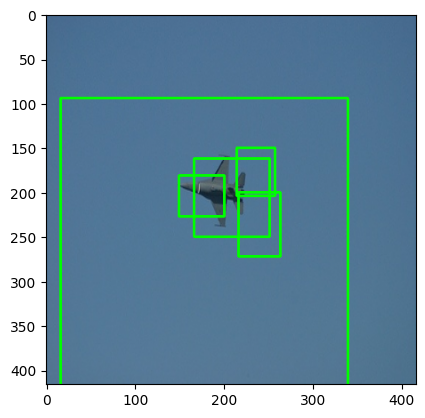

686
1/1 [==============================] - 0s 12ms/step


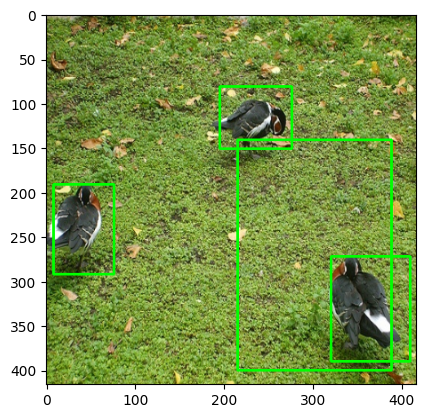

100
1/1 [==============================] - 0s 13ms/step


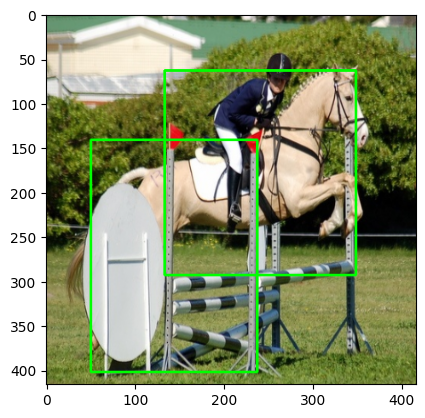

897
1/1 [==============================] - 0s 12ms/step


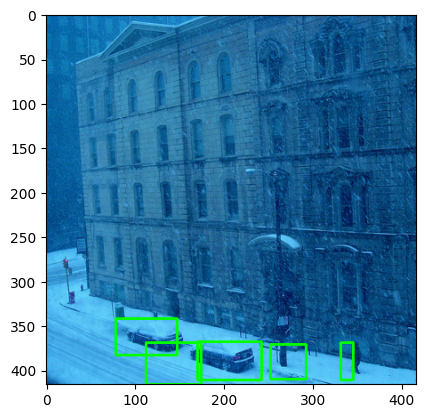

990
1/1 [==============================] - 0s 13ms/step


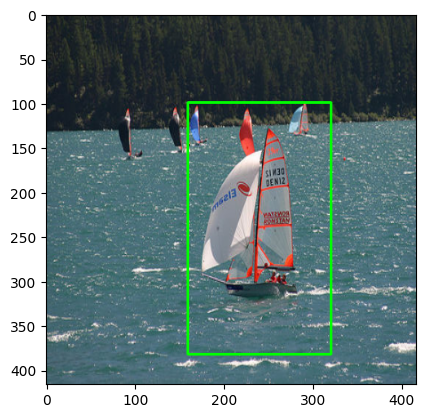

849
1/1 [==============================] - 0s 12ms/step


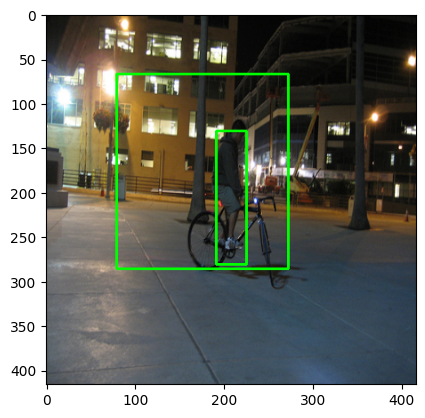

233
1/1 [==============================] - 0s 12ms/step


618
1/1 [==============================] - 0s 12ms/step


257
1/1 [==============================] - 0s 14ms/step


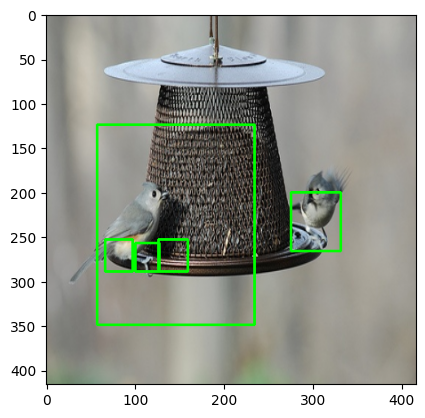

192
1/1 [==============================] - 0s 11ms/step


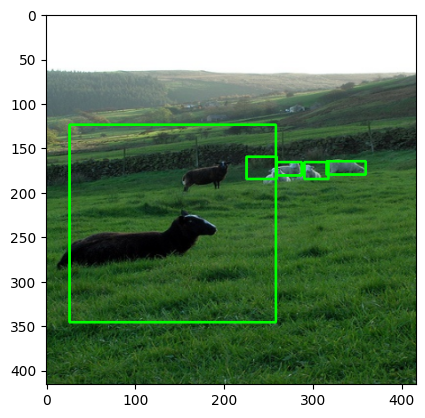

810
1/1 [==============================] - 0s 12ms/step


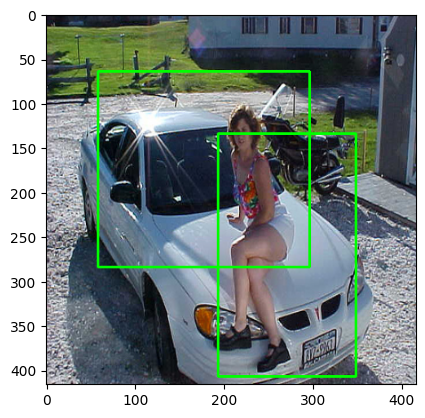

429
1/1 [==============================] - 0s 12ms/step


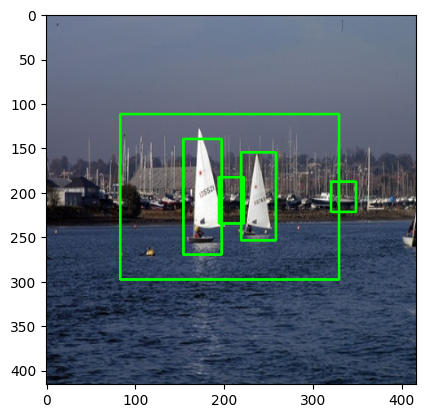

In [24]:
for i in [0,15,686,100,897,990,849,233,618,257,192,810,429]:
    
    print(i)
    
    images,attr = fun(train_image[i],416,416)
    final_images = tf.cast(tf.expand_dims(images, axis=0),tf.float32)
    
    k = model.predict(final_images)
    pred_xy = tf.sigmoid(k[..., :2]) + cell_grid
    pred_wh = tf.exp(k[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,4,2])   
    pred = tf.concat([pred_xy,pred_wh,tf.sigmoid(k[...,4:])],axis=-1)

    pred = pred[pred[...,4]>0.5]
    coord = []
    score = []
    for j in np.array(tf.argsort(pred[...,4])[::-1][:30]):
        coord.append(pred[j][:4]*416/13)
        score.append(pred[j][4])

    coord = np.array(coord)
    coord_ = coord.copy()

    coord_[:,0] = coord[:,0] - coord[:,2]/2
    coord_[:,1] = coord[:,1] - coord[:,3]/2
    coord_[:,2] = coord[:,0] + coord[:,2]/2
    coord_[:,3] = coord[:,1] + coord[:,3]/2

    nms_output = tf.image.non_max_suppression(
            coord_, score, max_output_size=5, iou_threshold=0.2)

    nms_coord = tf.gather(coord_, nms_output)

    image = images.copy()

    for j in nms_coord:

        x_min,y_min,x_max,y_max = j

        # Draw bounding box rectangle on the image.
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 1, 0), 2)

    plt.imshow(image)
    plt.show()